单目标：1 2 5  10   12  可以直接用mask获得最后的box

In [1]:
import os
import cv2
import numpy as np

# 设置文件路径
dataset_path = '/data/cxli/yuzhi/datasets/UCSDped2/UCSDped2/test/Test011/Test011_gt'
output_dir = 'box_gt'  # 结果保存文件夹
test_name = os.path.basename(os.path.dirname(dataset_path))  # 提取Test文件夹名称
output_file = os.path.join(output_dir, f'{test_name}_box.txt')  # 输出文件名

# 确保输出文件夹存在
os.makedirs(output_dir, exist_ok=True)
# 初始化结果列表
results = []

# 遍历所有的 .bmp 文件
for filename in sorted(os.listdir(dataset_path)):
    if filename.endswith('.bmp'):
        # 获取 frame_idx（从文件名提取）
        frame_idx = int(filename.split('.')[0])

        # 加载二值化 mask 图像
        mask_path = os.path.join(dataset_path, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # 找到所有连通区域的轮廓
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # 遍历每个轮廓，获取边界框
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_min, y_min, x_max, y_max = x, y, x + w, y + h
            
            # 固定track_id为1
            track_id = 0
            
            # 将结果添加到列表中
            results.append(f"{track_id},{frame_idx},{x_min},{y_min},{x_max},{y_max}")

# 保存结果到文件
with open(output_file, 'w') as f:
    for line in results:
        f.write(line + '\n')

print(f"Results saved to {output_file}")


Results saved to box_gt/Test011_box.txt


All .bmp files have been converted to .jpg.


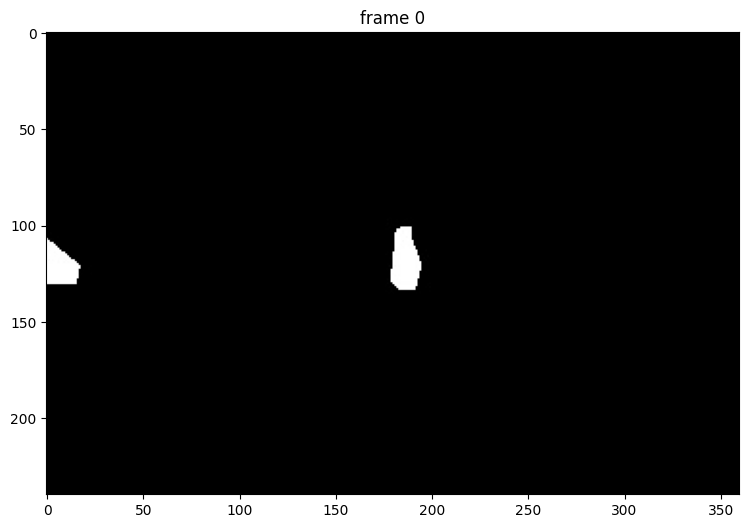

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from sam2.build_sam import build_sam2_video_predictor
device = torch.device("cuda:8")
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))



# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "/data/cxli/yuzhi/datasets/UCSDped2/UCSDped2/test/Test011/Test011_gt"

# 遍历文件夹中的所有文件
for filename in os.listdir(video_dir):
    if filename.endswith('.bmp'):
        # 构建完整的文件路径
        bmp_path = os.path.join(video_dir, filename)
        
        # 读取 .bmp 图像
        image = cv2.imread(bmp_path)
        
        # 构建新的 .jpg 文件路径
        jpg_filename = filename.replace('.bmp', '.jpg')
        jpg_path = os.path.join(video_dir, jpg_filename)
        
        # 保存为 .jpg 格式
        cv2.imwrite(jpg_path, image)
        
        # 删除原来的 .bmp 文件
        os.remove(bmp_path)
        
        print(f"Converted {filename} to {jpg_filename}")

print("All .bmp files have been converted to .jpg.")

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG",".bmp"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [2]:
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 180/180 [00:05<00:00, 30.79it/s]


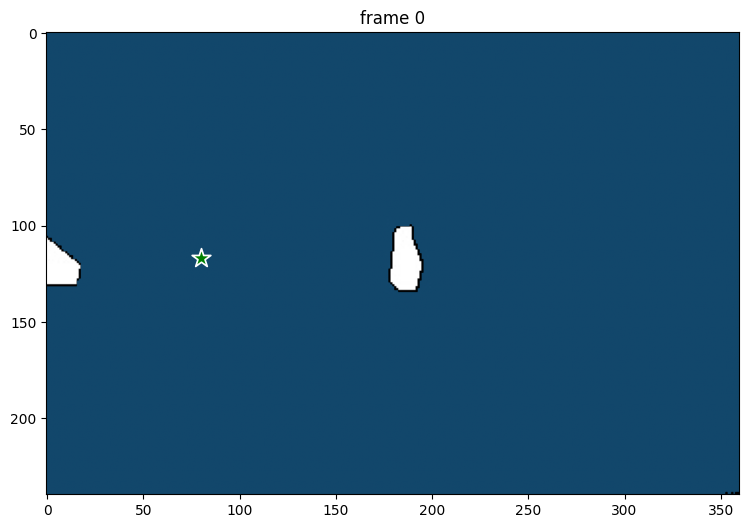

In [36]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[80, 117]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

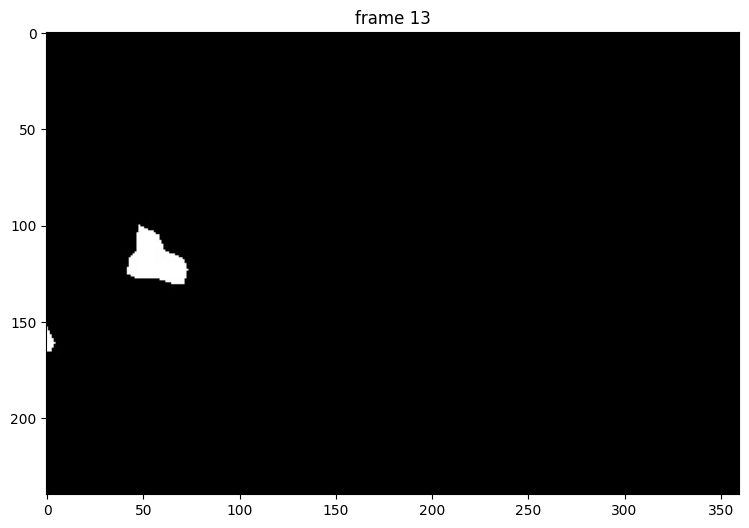

In [22]:
frame_idx = 13
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

/data/cxli/yuzhi/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/data/cxli/yuzhi/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/data/cxli/yuzhi/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:725.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/data/cxli/yuzhi/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Expected query, key and value to all be of dtype: 

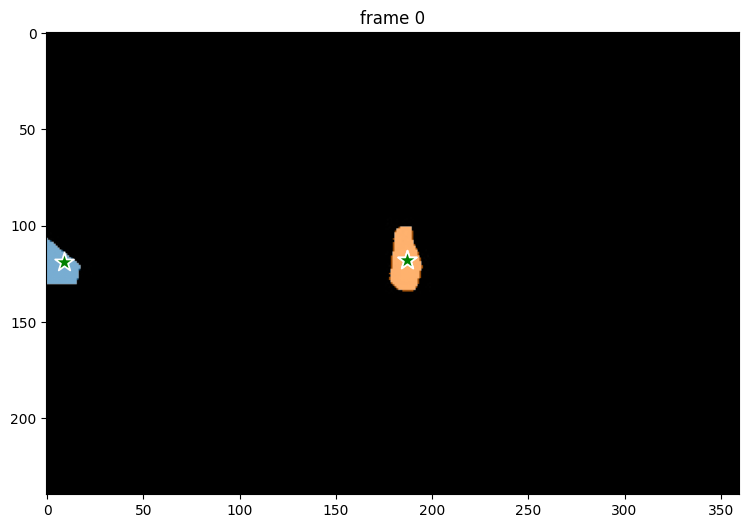

In [4]:

prompts = {}  # hold all the clicks we add for visualization
ann_frame_idx = 0  # the frame index we interact with
# give a unique id to each object we interact with (it can be any integers)
ann_obj_id=0
# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[9, 119]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

points = np.array([[187, 118]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
ann_obj_id=1
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)



# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

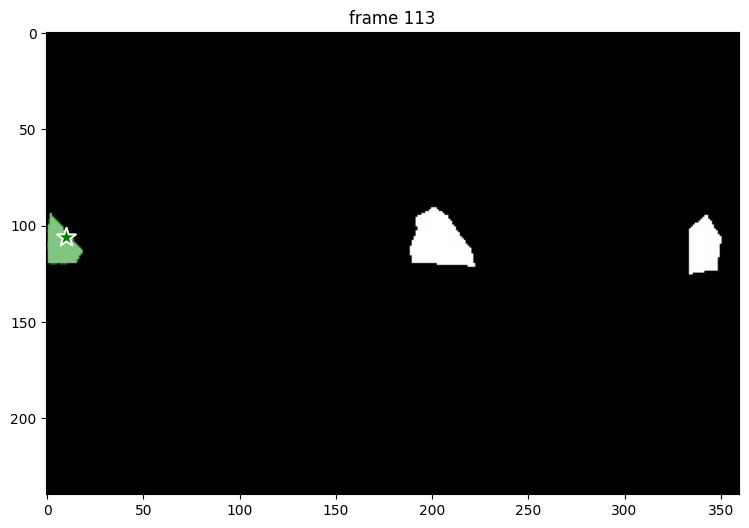

In [4]:

prompts = {}  # hold all the clicks we add for visualization
ann_frame_idx =113   # the frame index we interact with
 # give a unique id to each object we interact with (it can be any integers)
# ann_obj_id=0
# # Let's add a positive click at (x, y) = (210, 350) to get started
# points = np.array([[226, 106]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1], np.int32)
# prompts[ann_obj_id] = points, labels
# _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )

# points = np.array([[353, 110]], dtype=np.float32)
# # for labels, `1` means positive click and `0` means negative click
# labels = np.array([1], np.int32)
# ann_obj_id=1
# prompts[ann_obj_id] = points, labels
# _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
#     inference_state=inference_state,
#     frame_idx=ann_frame_idx,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )


points = np.array([[10, 106]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
ann_obj_id=2
prompts[ann_obj_id] = points, labels
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)



# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
for i, out_obj_id in enumerate(out_obj_ids):
    show_points(*prompts[out_obj_id], plt.gca())
    show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(113, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [8]:
import cv2
import numpy as np
import os

# 设置文件路径
dataset_path = '/data/cxli/yuzhi/datasets/UCSDped2/UCSDped2/test/Test011/Test011_gt'
output_dir = 'box_gt'  # 结果保存文件夹
test_name = os.path.basename(os.path.dirname(dataset_path))  # 提取Test文件夹名称
output_file = os.path.join(output_dir, f'{test_name}_box1.txt')  # 输出文件名
results = []

# 读取现有的文件数据并将其存储
existing_data = []
with open(output_file, 'r') as f:
    for line in f:
        existing_data.append(line.strip().split(','))

# 设置起始帧索引和新轨迹ID
start_frame_idx = 113
new_track_id = 2

# 遍历 video_segments，获取从指定索引开始的每个对象的 mask
for frame_idx, objects in video_segments.items():
    # 如果当前frame_idx小于start_frame_idx，跳过
    if frame_idx < start_frame_idx:
        continue

    # 遍历所有对象并计算边界框
    for obj_id, mask in objects.items():
        # 将 mask 转换为单通道的 uint8 类型
        mask_uint8 = ((mask > 0) * 255).astype(np.uint8)

        # 找到 mask 的轮廓
        contours, _ = cv2.findContours(mask_uint8[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # 遍历轮廓并计算边界框
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_min, y_min, x_max, y_max = x, y, x + w, y + h

            # 添加当前帧的新轨迹数据
            new_line = [str(new_track_id), str(frame_idx), str(x_min), str(y_min), str(x_max), str(y_max)]
            existing_data.append(new_line)

# 根据 frame_idx 排序
existing_data.sort(key=lambda x: int(x[1]))

# 将排序后的结果写回到文件
with open(output_file, 'w') as f:
    for line in existing_data:
        f.write(','.join(line) + '\n')

print(f"Modified and saved results to {output_file}")


Modified and saved results to box_gt/Test011_box1.txt


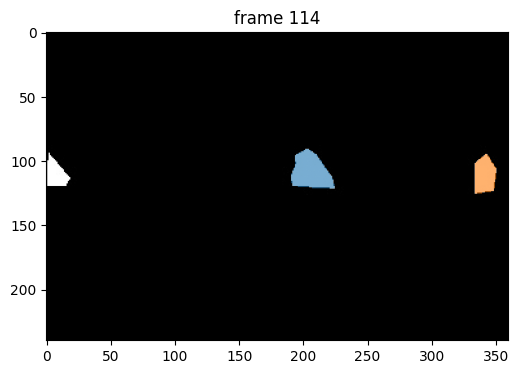

In [10]:
out_frame_idx=114
plt.figure(figsize=(6, 4))
plt.title(f"frame {out_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
for out_obj_id, out_mask in video_segments[out_frame_idx].items():
    show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

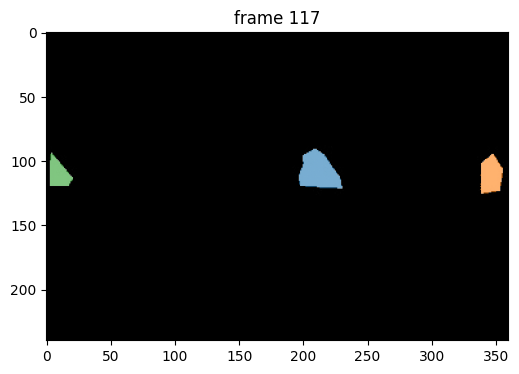

In [73]:
out_frame_idx=117
plt.figure(figsize=(6, 4))
plt.title(f"frame {out_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
for out_obj_id, out_mask in video_segments[out_frame_idx].items():
    show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [6]:
import cv2
import numpy as np
import os

# 设置文件路径
dataset_path = '/data/cxli/yuzhi/datasets/UCSDped2/UCSDped2/test/Test011/Test011_gt'
output_dir = 'box_gt'  # 结果保存文件夹
test_name = os.path.basename(os.path.dirname(dataset_path))  # 提取Test文件夹名称
output_file = os.path.join(output_dir, f'{test_name}_box1.txt')  # 输出文件名
results = []

# 遍历 video_segments，获取每个帧的每个对象的 mask
for frame_idx, objects in video_segments.items():
    for obj_id, mask in objects.items():
        # 将 mask 转换为单通道的 uint8 类型
        mask_uint8 = ((mask > 0) * 255).astype(np.uint8)

        # 找到 mask 的轮廓
        contours, _ = cv2.findContours(mask_uint8[0], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # 遍历轮廓并计算边界框
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_min, y_min, x_max, y_max = x, y, x + w, y + h
            
            # track_id 直接使用 obj_id
            track_id = obj_id
            
            # 将结果添加到列表
            results.append(f"{track_id},{frame_idx},{x_min},{y_min},{x_max},{y_max}")

# 将结果保存到文件
with open(output_file, 'w') as f:
    for line in results:
        f.write(line + '\n')

print(f"Results saved to {output_file}")


Results saved to box_gt/Test011_box1.txt


In [31]:
# 文件路径
file_path = '/data/cxli/yuzhi/segment-anything-2/box_gt/Test004_box.txt'
output_path = '/data/cxli/yuzhi/segment-anything-2/box_gt/Test004_box_modified.txt'

# 用于存储结果
results = []

# 用于追踪前一行的帧编号
previous_frame_idx = None

# 打开文件并逐行读取
with open(file_path, 'r') as file:
    for line in file:
        # 解析当前行
        track_id, frame_idx, x_min, y_min, x_max, y_max = line.strip().split(',')
        
        # 如果当前帧编号和前一行的帧编号相同，则设置track_id为1，否则为0
        if frame_idx == previous_frame_idx:
            track_id = '1'
        else:
            track_id = '0'
        
        # 更新 previous_frame_idx 为当前帧编号
        previous_frame_idx = frame_idx
        
        # 添加修改后的行到结果列表
        results.append(f"{track_id},{frame_idx},{x_min},{y_min},{x_max},{y_max}")

# 将结果写入新的文件
with open(output_path, 'w') as output_file:
    for line in results:
        output_file.write(line + '\n')

print(f"Modified file saved to {output_path}")


Modified file saved to /data/cxli/yuzhi/segment-anything-2/box_gt/Test004_box_modified.txt


In [9]:
# 文件路径
file_path = '/data/cxli/yuzhi/segment-anything-2/box_gt/Test011_box.txt'

# 自定义的加值
x = 1  # 你可以根据需要修改这个值

# 初始化结果列表
results = []

# 逐行读取原始文件并修改 frame_idx
with open(file_path, 'r') as file:
    for line in file:
        # 按逗号分割行内容并解析字段
        track_id, frame_idx, x_min, y_min, x_max, y_max = line.strip().split(',')
        
        # 将 frame_idx 转换为整数，加上自定义值 x
        frame_idx = str(int(frame_idx) + x)
        
        # 将修改后的行添加到结果列表
        results.append(f"{track_id},{frame_idx},{x_min},{y_min},{x_max},{y_max}")

# 将修改后的结果写回原文件
with open(file_path, 'w') as file:
    for line in results:
        file.write(line + '\n')

print(f"Modified file saved to {file_path}")


Modified file saved to /data/cxli/yuzhi/segment-anything-2/box_gt/Test011_box.txt
